# Wasserstein GAN and Wasserstein GAN-GP
The initial Convolutional Model setup is Taken from: https://arxiv.org/abs/1511.06434
The Training implementation of GAN is taken from this paper : https://arxiv.org/abs/1701.07875. and the GAN-GP from: https://arxiv.org/abs/1704.00028. the model structure almost remains the same as DCGAN with little bit changing in discriminator. The hyperparameters and mainly the Loss calculation will differ.

In [92]:
!pip install tensorboard

In [126]:
# Importing specific dependencies for the project.
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

In [127]:
!pip install tqdm
from tqdm import tqdm

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


## Hyperparameters

In [128]:
# Setting the hyperparameters
device = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-4
BATCH_SIZE = 64
IMAGE_SIZE = 64
CHANNELS_IMG = 3
Z_DIM = 100
NUM_EPOCHS = 50
FEATURES_CRITIC = 64
FEATURES_GEN = 64
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10
# Setting the Transforms
transforms = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)
     

## Dataset Subset

In [60]:
# Using the Celeb dataset.
dataset_path = '/kaggle/input/celeba-dataset/img_align_celeba'
dataset = datasets.ImageFolder(root= dataset_path, transform=transforms)

In [64]:
import numpy as np
from torch.utils.data import Subset
# Create a random subset
indices = np.random.choice(len(dataset), size=5000, replace=False)  # Adjust size as needed
subset = Subset(dataset, indices)

# Create a DataLoader for the subset
loader = DataLoader(
    subset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

## Model

In [129]:
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)

class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            self._block(channels_noise, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(features_g * 2, channels_img, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),  # Output: N x channels_img x 64 x 64
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

def test():
    N, in_channels, H, W = 8, 3, 64, 64
    noise_dim = 100
    x = torch.randn((N, in_channels, H, W))
    disc = Discriminator(in_channels, 8)
    assert disc(x).shape == (N, 1, 1, 1), "Discriminator test failed"
    gen = Generator(noise_dim, in_channels, 8)
    z = torch.randn((N, noise_dim, 1, 1))
    assert gen(z).shape == (N, in_channels, H, W), "Generator test failed"

test()


In [130]:
# Defining objects for Generator and discriminator
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
critic = Discriminator(CHANNELS_IMG, FEATURES_CRITIC).to(device)
initialize_weights(gen)
initialize_weights(critic)

# initializate optimizer
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
opt_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))

# for tensorboard plotting
fixed_noise = torch.randn(64, Z_DIM, 1, 1).to(device)
writer_real = SummaryWriter(f"logs/Celeb_A/real")
writer_fake = SummaryWriter(f"logs/Celeb_A/fake")
step = 0

gen.train()
critic.train()

Discriminator(
  (disc): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
  )
)

## TensorBoard

In [81]:
# loading tensorboard
%reload_ext tensorboard
%tensorboard --logdir Evaluation

## Gradient Penalty

In [131]:
def gradient_penalty(critic, real, fake, device):
    BATCH_SIZE, C, H, W = real.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    
    # Ensure fake has the same dimensions as real
    assert real.shape == fake.shape, "Mismatch in dimensions of real and fake tensors"
    
    interpolated_images = real * alpha + fake * (1 - alpha)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty


## Training Loop

In [85]:
# Training Loop. also saving the model parameters after 10 epochs

for epoch in range(NUM_EPOCHS):
    # Target labels not needed! <3 unsupervised
    for batch_idx, (real, _) in enumerate(tqdm(loader)):
        real = real.to(device)
        cur_batch_size = real.shape[0]

        # Train Critic: max E[critic(real)] - E[critic(fake)]
        # equivalent to minimizing the negative of that
        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(device)
            fake = gen(noise)
            critic_real = critic(real).reshape(-1)
            critic_fake = critic(fake).reshape(-1)
            gp = gradient_penalty(critic, real, fake, device=device)
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp
            )
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        gen_fake = critic(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # model save
        if epoch % 10 == 0 and batch_idx == 0:
          torch.save(gen.state_dict(), f'WGAN_Gen{epoch}.pth')
          torch.save(critic.state_dict(), f'WGAN_Critic{epoch}.pth')
          print(f'Saved checkpoint for epoch{epoch}')

        # Print losses occasionally and print to tensorboard
        if batch_idx % 100 == 0 and batch_idx > 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(loader)} \
                  Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise)
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)

                writer_real.add_image("real", img_grid_real, global_step=step)
                writer_fake.add_image("fake", img_grid_fake, global_step=step)

            step += 1

  1%|▏         | 1/79 [00:01<02:13,  1.72s/it]

Saved checkpoint for epoch0


  1%|▏         | 1/79 [00:01<01:38,  1.26s/it]

Saved checkpoint for epoch10


  1%|▏         | 1/79 [00:01<01:38,  1.26s/it]

Saved checkpoint for epoch20


  1%|▏         | 1/79 [00:01<01:37,  1.25s/it]

Saved checkpoint for epoch30


  1%|▏         | 1/79 [00:01<01:38,  1.27s/it]

Saved checkpoint for epoch40


100%|██████████| 79/79 [01:22<00:00,  1.05s/it]


In [91]:
# Saving the Final Model
torch.save(gen.state_dict(), 'WGAN_Gen.pth')
torch.save(critic.state_dict(), 'WGAN_Critic.pth')

In [132]:
gen.load_state_dict(torch.load(f'WGAN_Gen.pth'))
critic.load_state_dict(torch.load(f'WGAN_Critic.pth'))

/tmp/ipykernel_36/179753316.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gen.load_state_dict(torch.load(f'WGAN_Gen190.pth'))
/tmp/ipykernel_36/179753316.py:2: FutureW

<All keys matched successfully>

## Image Evaluation

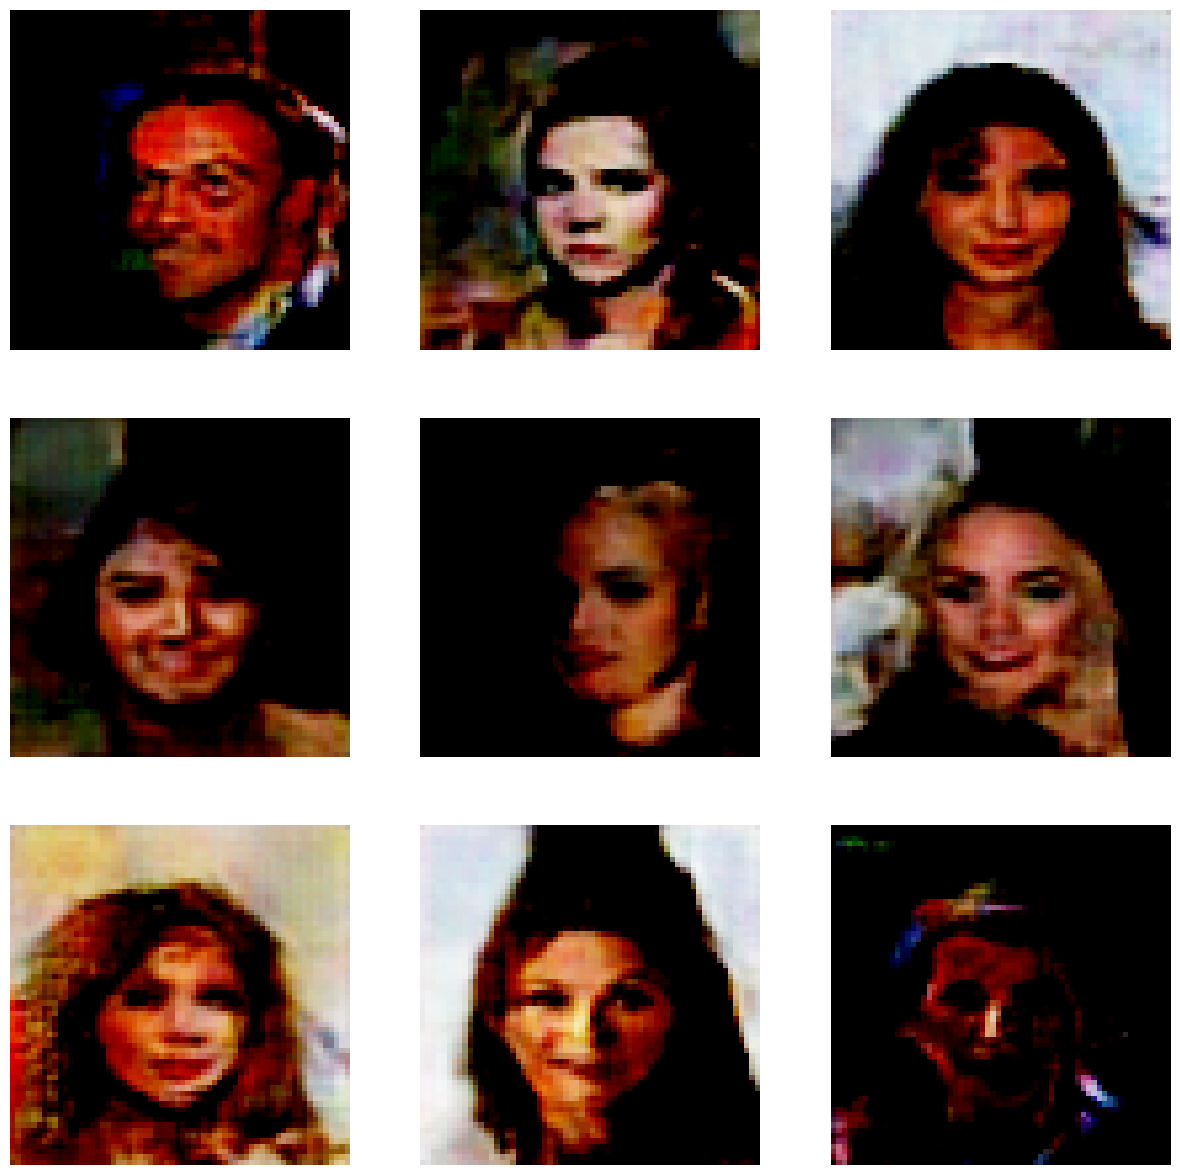

In [140]:
import matplotlib.pyplot as plt
with torch.no_grad():
    noise = torch.randn(9, Z_DIM, 1, 1).to(device)
    img = gen(noise)
img = img.cpu().numpy()
img = np.transpose(img, (0, 2, 3, 1))
fig, axes = plt.subplots(3, 3, figsize=(15, 15))  # Create a 3x3 grid of subplots
for i in range(3):
    for j in range(3):
        axes[i, j].imshow(img[i*3 +j])  # Use the calculated index to access each image
        axes[i, j].axis('off')  # Hide axis
plt.show()